## Creating Plots

This notebook takes as input data from three MCMC runs (Utah, Texas, North Carolina) and makes 7 plots per state, as seen in the Partisan Symmetry paper. 

In [1]:
import geopandas as gpd
import numpy as np
import matplotlib
#matplotlib.use('Agg')
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import json
import os
import pandas as pd

import os
from functools import partial
import json
import csv

import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import networkx as nx
import pandas as pd
import numpy as np
from tqdm import tqdm_notebook
import random
import seaborn as sns

## Helper functions
This cell contains several helper functions to generate the plots

In [23]:
def binning_seats(data):
    seats_data = []
    for i in range(len(data)):
        seats_data.append(data["seats"][i])
    return max(seats_data) - min(seats_data) + 1


def make_full_lists(data):
    all_seats = []
    all_mms = []
    all_pgs = []
    for i in range(len(data)):
        all_seats.append(data["seats"][i])
        all_mms.append(data["mm"][i])
        all_pgs.append(data["pg"][i])
    return all_seats, all_pgs, all_mms


def make_winnowed_lists(data, inliers, pg_bound, mm_bound):
    mm_routliers = []
    mm_doutliers = []
    pg_routliers = []
    pg_doutliers = []
    vs_routliers = []
    vs_doutliers = []
    ideal_pg_seats = []
    ideal_mm_seats = []

    for i in range(len(data)):
        if data["seats"][i] < inliers[0]:
            mm_doutliers.append(data["mm"][i])
            pg_doutliers.append(data["pg"][i])
            vs_doutliers.append(data["vs"][i])
        if data["seats"][i] > inliers[1]:
            mm_routliers.append(data["mm"][i])
            pg_routliers.append(data["pg"][i])
            vs_routliers.append(data["vs"][i])
        if data["pg"][i] < pg_bound:
            ideal_pg_seats.append(data["seats"][i])
        if abs(data["mm"][i]) < mm_bound:
            ideal_mm_seats.append(data["seats"][i])

    outlying_mms = [mm_routliers, mm_doutliers]
    outlying_pgs = [pg_routliers, pg_doutliers]

    return outlying_pgs, outlying_mms, len(mm_doutliers) + len(mm_routliers), ideal_pg_seats, ideal_mm_seats

def visualize(state, data, inliers, num_dist, pg_bound, mm_bound,state_name,election_name,bound_name, newdir, showPlots=True):

    if state[0] == "U" and election_name == "SEN16":
        v_bar = 0.7155
        use_Prop = True
    elif state[0] == "T" and election_name == "SEN12":
        v_bar = 0.5815
        use_Prop = True
    elif state[0] == "N" and election_name == "SEN16":
        v_bar = 0.5302
        use_Prop = True
    else:
        v_bar = 0
        use_Prop = False

    # Setting up figures
    fig1, seats = plt.subplots(figsize=(16,4))
    fig2, pg_seats = plt.subplots(figsize=(16,4))
    fig3, mm_seats = plt.subplots(figsize=(16,4))
    fig4, ax = plt.subplots(2,2, figsize=(16,8), sharex="col", sharey="row")

    seats_figs = [seats, pg_seats, mm_seats]

    # Spacing of subplots
    plt.subplots_adjust(wspace=0.3, hspace=0.3)

    # Colors
    party_colors = ["red", "blue"]
    neutral = "lightgray"

    # Variables
    bins_num = 20
    out_bins_num = binning_seats(data)
    num_steps = len(data)

    # Formatting data
    all_seats, all_pgs, all_mms = make_full_lists(data)
    outlying_pgs, outlying_mms, num_outliers, ideal_pg_seats, ideal_mm_seats = make_winnowed_lists(data, inliers, pg_bound, mm_bound)

    # More Variables
    num_best_pgs = len(ideal_pg_seats)
    num_best_mms = len(ideal_mm_seats)
    pct_outliers = round(num_outliers / num_steps * 100, 1)
    pct_best_pgs = round((num_best_pgs/num_steps) * 100,1)
    pct_best_mms = round((num_best_mms/num_steps) * 100,1)
    
    custom_lines = [[Line2D([0], [0], color="blue", lw=4)],
                   [Line2D([0], [0], color="blue", lw=4)],
                   [Line2D([0], [0], color="blue", lw=4)]]

    outlier_labels = ["Dem. leaning plans"]
    if state[0] == 'T' or state[0] == 'N':
        for i in range(3):
            custom_lines[i].append(Line2D([0], [0], color="red", lw=4))
        outlier_labels.append("Rep. leaning plans")
    
    if use_Prop:
        for i in range(3):
            custom_lines[i].append(Line2D([0], [0], color="darkgreen", lw=2, ls='solid'))
        outlier_labels.append(str(v_bar*100) + "%")

    # Titles
    all_plans_title = state + ": " + str(num_steps) + " ReCom plans"
    outlying_seats_title = state + ": " + str(num_outliers) + " outlier plans " + "(" + str(pct_outliers) + "%)"
    all_seats_title = state + ": Republican seats won: " + str(num_steps) + " ReCom plans"
    ideal_pgs_title = state + " Republican seats won: " + str(num_best_pgs) + " plans with PG < " + str(pg_bound) + " (" + str(pct_best_pgs) + "% of all plans)"
    ideal_mms_title = state + " Republican seats won: " + str(num_best_mms) + " plans with |MM| < " + str(mm_bound) + " (" + str(pct_best_mms) + "% of all plans)"

    seats_titles = [all_seats_title, ideal_pgs_title, ideal_mms_title]

    # Plotting the data into the figures
    n, bins, patches = seats.hist(all_seats, bins=range(num_dist+2), color=neutral)#was plus 1 missed for UT?
    for i in range(num_dist):
        if i < inliers[0]:
            patches[i].set_fc("blue")
        if i > inliers[1]:
            patches[i].set_fc("red")
    n, bins, patches = pg_seats.hist(ideal_pg_seats, bins=range(num_dist+2), color=neutral)#was plus 1 missed for UT?
    for i in range(num_dist):
        if i < inliers[0]:
            patches[i].set_fc("blue")
        if i > inliers[1]:
            patches[i].set_fc("red")
    n, bins, patches = mm_seats.hist(ideal_mm_seats, bins=range(num_dist+2), color=neutral)#was plus 1 missed for UT?
    for i in range(num_dist):
        if i < inliers[0]:
            patches[i].set_fc("blue")
        if i > inliers[1]:
            patches[i].set_fc("red")

    ax[0,0].hist(all_mms, bins=2*bins_num, color=neutral)
    ax[0,1].hist(all_pgs, bins=2*bins_num, color=neutral)
    ax[1,0].hist(outlying_mms, bins=bins_num, color=party_colors)
    ax[1,1].hist(outlying_pgs, bins=bins_num, color=party_colors)


    # Aesthetics for figures
    for i in seats_figs:
        i.set_ylabel("Frequency")
        i.set_xlabel("# Seats Won")
        i.set_xlim(0, num_dist+1)
        i.set_xticks([x+.5 for x in range(num_dist + 2)])
        i.set_xticklabels(range(num_dist + 1))
        if use_Prop:
            i.axvline(x=(num_dist*v_bar) + 0.5, color="darkgreen", linestyle="solid", linewidth=2)
        for j in range(-2,num_dist+2):
            i.axvline(x=(j), color="gray", linewidth=0.5)
        i.grid(axis='y')

    for i in range(3):
        seats_figs[i].set_title(seats_titles[i])
        leg1 = seats_figs[i].legend(custom_lines[i], outlier_labels)
        seats_figs[i].add_artist(leg1)

    for i in [0,1]:
        for j in [0,1]:
            ax[i,j].grid()
            ax[i,j].set_ylabel("Frequency")
            ax[i,j].tick_params(labelleft=True, labelbottom=True)
            if j == 0:
                ax[i,j].set_xlabel("Mean-Median Score")
                ax[i,j].axvline(x=0, color="black", linewidth=2, linestyle="dashed", label="MM = 0 (ideal)")
            else:
                ax[i,j].set_xlabel("Partisan Gini Score")
                ax[i,j].axvline(x=0, color="black", linewidth=2, linestyle="dashed", label="PG = 0 (ideal)")
            if i == 0:
                ax[i,j].set_title(all_plans_title)
            else:
                ax[i,j].set_title(outlying_seats_title)
            ax[i,j].legend()

    fig1.savefig(newdir+state_name+election_name+"_"+bound_name+"_seats.png")
    fig2.savefig(newdir+state_name+election_name+"_"+bound_name+"_pgseats.png")
    fig3.savefig(newdir+state_name+election_name+"_"+bound_name+"_mmseats.png")
    fig4.savefig(newdir+state_name+election_name+"_"+bound_name+"_all.png")
    
    if showPlots:
        plt.show(fig1)
        plt.show(fig2)
        plt.show(fig3)
        plt.show(fig4)

    plt.close(fig1)
    plt.close(fig2)
    plt.close(fig3)
    plt.close(fig4)

## Make plots
Use the makePlot function to generate a plot for a specific state/election. Change the parameters in the if block of this function to customize the plot (you can do this after generating a default plot and seeing how it looks. The default parameters are set to look nice on NC-SEN16, TX-SEN12, and UT-SEN16, which are the elections we focus on in the paper.

In [24]:
def makePlot(state_name, election_name):
    steps = 100000 # (make this accord to your chain run)
    if state_name[0] == "n":
        state_abbr = "NC"
        bounds = [7,10]
        districts = 13
        pg_bound = 0.01
    elif state_name[0] == "t":
        state_abbr = "TX"
        bounds = [22,27]
        districts = 36
        pg_bound = 0.03
    elif state_name[0] == "u":
        state_abbr = "UT"
        bounds = [4,4]
        districts = 4
        pg_bound = 0.01

    datadir = "./" + state_abbr + "output/"

    newdir = "./Final_Paper_Plots/"
    os.makedirs(os.path.dirname(newdir + "init.txt"), exist_ok=True)
    with open(newdir + "init.txt", "w") as f:
        f.write("Created Folder")


    max_steps = steps
    step_size = 10000

    ts = [x*step_size for x in range(1,int(max_steps/step_size)+1)]

    df = pd.DataFrame(columns = ['seats','mm','pg','vs','eg','ce'])

    for t in ts:
        tempdf = pd.read_csv(datadir + state_name + election_name +"_data"+str(t)+".csv", delimiter=',')
        df = pd.concat([df, tempdf], ignore_index=True)
        
    visualize(state_abbr+"-"+election_name, df, bounds, districts, pg_bound, 0.001, state_name, election_name, str(bounds), newdir)
    return

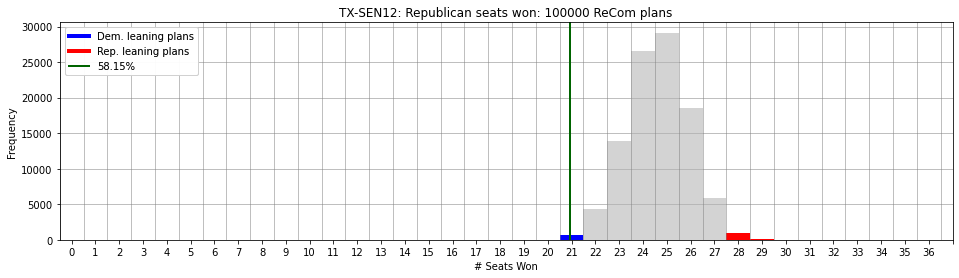

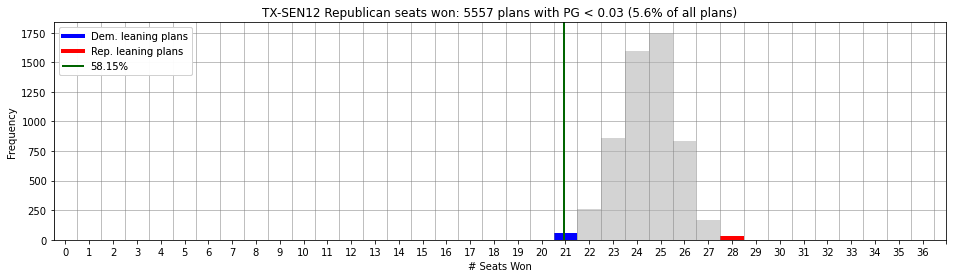

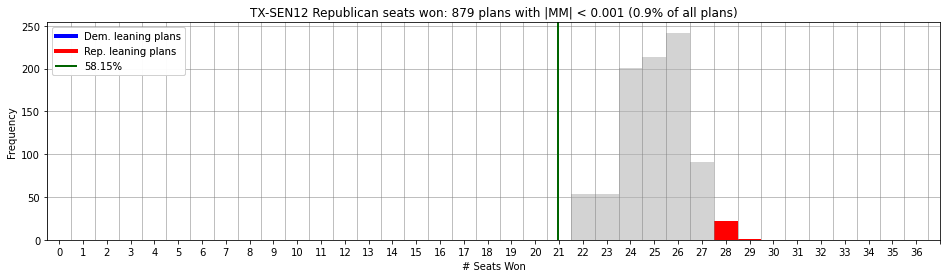

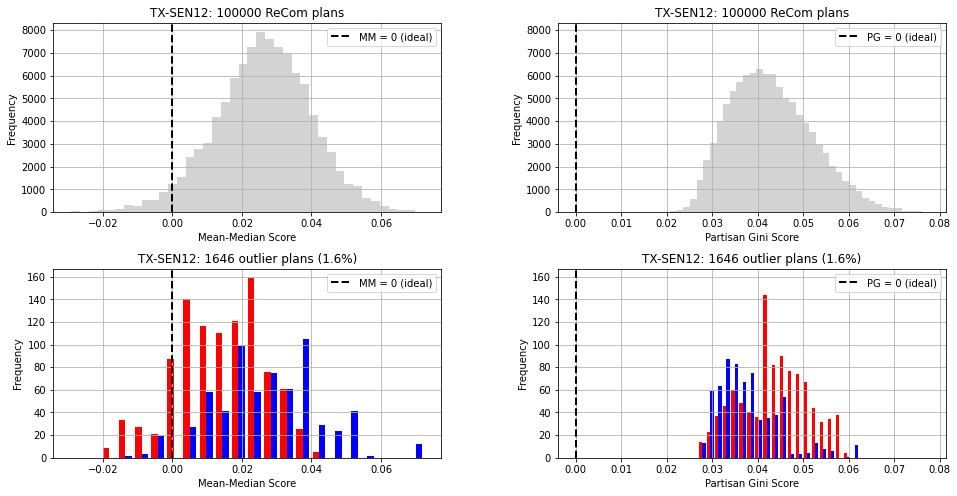

In [25]:
# Example plot:
makePlot("texas", "SEN12")

## Generating all plots
Run the below cell to generate every plot for every state/election on which we have data, using our pre-set bounds on seats outliers. Running this cell will take several minutes.

In [35]:
%%time

abbrs = ["NC", "TX", "UT"]

names=["northcarolina","texas","utah"]

elects = [ ["GOV08", "SEN08", "SEN10", "GOV12", "SEN14", "PRES12", "PRES16", "SEN16", "GOV16"],
 ["PRES12", "SEN12", "SEN14", "GOV14", "PRES16"],
 ['PRES16', 'SEN16', 'GOV16']]

bounds = [
[ # north carolina
[[4,5]],
[[2,4]],
[[9,11]],
[[8,11]],
[[6,9]],
[[6,9]],
[[6,9]],
[[7,10]],
[[6,9]]
],
[ # texas
[[21,27]],
[[22,27]],
[[25,30]],
[[23,28]],
[[18,23]]
],
[ # utah
[[3,3]],
[[4,4]],
[[4,4]]
]
]

districts = [13,36,4]
steps = [100000,100000,100000]
pgvalue = [.01,.03,.01]

for i in range(3):
    temp = 0
    for ename in elects[i]:
        for bound_name in [0]:

            print("Plotting",names[i],ename)
            print("Bounds",bounds[i][temp][bound_name])
            showPlots = False

            election_name = ename
            state_name = names[i]
            state_abbr = abbrs[i]

            datadir = "./" + state_abbr + "output/"

            newdir = "./Final_Paper_Plots/"
            os.makedirs(os.path.dirname(newdir + "init.txt"), exist_ok=True)
            with open(newdir + "init.txt", "w") as f:
                f.write("Created Folder")


            max_steps = steps[i]
            step_size = 10000

            ts = [x*step_size for x in range(1,int(max_steps/step_size)+1)]

            df = pd.DataFrame(columns = ['seats','mm','pg','vs','eg','ce'])

            for t in ts:
                tempdf = pd.read_csv(datadir + state_name + election_name +"_data"+str(t)+".csv", delimiter=',')
                df = pd.concat([df, tempdf], ignore_index=True)
            visualize(abbrs[i]+"-"+ename, df, bounds[i][temp][bound_name], districts[i], pgvalue[i], 0.001, abbrs[i] + "_", ename,str(bounds[i][temp][bound_name]), newdir, showPlots)

        temp+=1

Plotting northcarolina GOV08
Bounds [4, 5]
Plotting northcarolina SEN08
Bounds [2, 4]
Plotting northcarolina SEN10
Bounds [9, 11]
Plotting northcarolina GOV12
Bounds [8, 11]
Plotting northcarolina SEN14
Bounds [6, 9]
Plotting northcarolina PRES12
Bounds [6, 9]
Plotting northcarolina PRES16
Bounds [6, 9]
Plotting northcarolina SEN16
Bounds [7, 10]
Plotting northcarolina GOV16
Bounds [6, 9]
Plotting texas PRES12
Bounds [21, 27]
Plotting texas SEN12
Bounds [22, 27]
Plotting texas SEN14
Bounds [25, 30]
Plotting texas GOV14
Bounds [23, 28]
Plotting texas PRES16
Bounds [18, 23]
Plotting utah PRES16
Bounds [3, 3]
Plotting utah SEN16
Bounds [4, 4]
Plotting utah GOV16
Bounds [4, 4]
CPU times: user 3min 52s, sys: 3.46 s, total: 3min 56s
Wall time: 4min
